In [1]:
import torch

# layer 비교하기 traffic 데이터를 가져오는 식으로 비교
from layers.Embed import *

import torch.nn as nn
import torch.nn.functional as F
from layers.Transformer_EncDec import Encoder, EncoderLayer
from layers.SelfAttention_Family import FullAttention, AttentionLayer
import numpy as np

In [3]:
# weather 데이터셋 가져오기
import pandas as pd
weather_path = './dataset/weather/weather_re.csv'

df_weather = pd.read_csv(weather_path)

In [4]:
df_weather

,date,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),...,wv (m/s),max. wv (m/s),wd (deg),rain (mm),raining (s),SWDR (W/m�),PAR (�mol/m�/s),max. PAR (�mol/m�/s),Tlog (degC),OT
0,2020-01-01 00:10:00,1008.89,0.71,273.18,-1.33,86.1,6.43,5.54,0.89,3.42,...,1.02,1.60,224.3,0.0,0.0,0.0,0.0,0.0,11.45,428.1
1,2020-01-01 00:20:00,1008.76,0.75,273.22,-1.44,85.2,6.45,5.49,0.95,3.39,...,0.43,0.84,206.8,0.0,0.0,0.0,0.0,0.0,11.51,428.0
2,2020-01-01 00:30:00,1008.66,0.73,273.21,-1.48,85.1,6.44,5.48,0.96,3.39,...,0.61,1.48,197.1,0.0,0.0,0.0,0.0,0.0,11.60,427.6
3,2020-01-01 00:40:00,1008.64,0.37,272.86,-1.64,86.3,6.27,5.41,0.86,3.35,...,1.11,1.48,206.4,0.0,0.0,0.0,0.0,0.0,11.70,430.0
4,2020-01-01 00:50:00,1008.61,0.33,272.82,-1.50,87.4,6.26,5.47,0.79,3.38,...,0.49,1.40,209.6,0.0,0.0,0.0,0.0,0.0,11.81,432.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52691,2020-12-31 23:20:00,978.32,2.28,277.16,-0.80,80.0,7.20,5.76,1.44,3.67,...,0.73,1.40,180.6,0.0,0.0,0.0,0.0,0.0,13.40,433.0
52692,2020-12-31 23:30:00,978.30,2.13,277.01,-0.43,83.1,7.12,5.92,1.20,3.77,...,0.43,0.82,174.0,0.0,0.0,0.0,0.0,0.0,13.42,439.6
52693,2020-12-31 23:40:00,978.26,1.99,276.88,-0.71,82.2,7.05,5.80,1.26,3.69,...,0.38,0.76,248.9,0.0,0.0,0.0,0.0,0.0,13.45,435.2
52694,2020-12-31 23:50:00,978.26,2.07,276.95,-0.77,81.4,7.09,5.77,1.32,3.68,...,0.57,1.07,196.6,0.0,0.0,0.0,0.0,0.0,13.47,433.9


In [17]:
df_data = df_weather.drop('date', axis=1)

In [7]:
# train, evaluate, test 나누어서 가져오기
from data_provider.data_factory import data_provider

In [9]:
# 데이터 훈련/검증/테스트용 숫자
num_df = len(df_weather)
num_train = int(len(df_weather) * 0.7)
num_test = int(len(df_weather) * 0.2)
num_vali = len(df_weather) - num_train - num_test

In [12]:
# 변수 정리

seq_len = 96 # c_in으로 
label_len = 48
pred_len = 96
e_layers = 2
d_layers = 1
factor = 3
enc_in = 21
dec_in = 21
d_model = 256
batch_size = 32
c_out = 321
des = 'Exp'
learning_rate = 0.001
freq = 'h' # 입력빈도 - 세팅을 일일이 해야 하는 부분
dropout = 0.1
embed = 'timeF' # timeF, fixed, learned
class_strategy = 'projection'

In [13]:
# 
border1s = [0, num_train - seq_len, num_df - num_test - seq_len]
border2s = [num_train, num_train + num_vali, num_df]
# train - 0, vali - 1, test -2 
border1_train = border1s[0]
border2_train = border2s[0]
border1_vali = border1s[1]
border2_vali = border2s[1]
border1_test = border1s[2]
border2_test = border2s[2]
border1_train, border2_train, border1_vali, border2_vali, border1_test, border2_test # train, vali, test 경계

(0, 36887, 36791, 42157, 42061, 52696)

In [18]:
cols_data = df_data.columns

In [19]:
# scaling
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_data = df_data[border1s[0]:border2s[0]]
scaler.fit(train_data) # train_data에 대해서만 standardscaler 적용 - validation, test 데이터에서는 확인 불가.

data = scaler.transform(df_data)

In [21]:
data_train = data[border1_train:border2_train]
data_vali = data[border1_vali:border2_vali]
data_test = data[border1_test:border2_test]

In [24]:
data_train.shape, data_vali.shape, data_test.shape

((36887, 21), (5366, 21), (10635, 21))

In [25]:
## 범위 확인했으니 이번엔 Exp_Long_Term_Forecast 객체 불러오기

In [27]:
# run.py 참조
from experiments.exp_long_term_forecasting import Exp_Long_Term_Forecast
import argparse

In [ ]:
# train -> 96 input, 96 output (1~36696까지 학습)
# train 36696 - 
# val 5175
# test 10444

In [28]:
# 이제 데이터 분석하기 - 전체 추세 분석

In [78]:
# 그러면 train, vali, test 데이터 연결

for j in range(21):
    print(j, data[:,j].mean(), data[:,j].std())

0 -0.07568662093859505 1.066779237219162
1 -0.150354890824375 0.9676329557168367
2 -0.1405340135087783 0.9621364155886339
3 -0.010102047401341468 0.9214560372627694
4 0.26430819534878836 1.0253219768198485
5 -0.14759755695668025 0.9412764830170274
6 -0.03812825951742943 0.9152177094911151
7 -0.17437399142297216 0.9384266577020154
8 -0.037344444774130424 0.9148643533305568
9 -0.03711617490176873 0.9149941708849183
10 0.10850342809769119 0.9569644772115139
11 -0.019687306759618575 0.960656843433396
12 -0.049323454965301945 0.9485577027664879
13 0.009946546107336958 0.9336511602645651
14 0.0023796206601322694 1.0041025741115348
15 0.024873947669297118 1.0584263365886544
16 -0.1227498397214914 0.9034888325417341
17 -0.12429492671119936 0.9032741973128567
18 -0.12674751203243964 0.9001036002762346
19 -0.16251138309063531 0.9765043047937393
20 0.13782208951753758 1.0286527241888606


In [35]:
df_data

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),...,wv (m/s),max. wv (m/s),wd (deg),rain (mm),raining (s),SWDR (W/m�),PAR (�mol/m�/s),max. PAR (�mol/m�/s),Tlog (degC),OT
0,1008.89,0.71,273.18,-1.33,86.1,6.43,5.54,0.89,3.42,5.49,...,1.02,1.60,224.3,0.0,0.0,0.0,0.0,0.0,11.45,428.1
1,1008.76,0.75,273.22,-1.44,85.2,6.45,5.49,0.95,3.39,5.45,...,0.43,0.84,206.8,0.0,0.0,0.0,0.0,0.0,11.51,428.0
2,1008.66,0.73,273.21,-1.48,85.1,6.44,5.48,0.96,3.39,5.43,...,0.61,1.48,197.1,0.0,0.0,0.0,0.0,0.0,11.60,427.6
3,1008.64,0.37,272.86,-1.64,86.3,6.27,5.41,0.86,3.35,5.37,...,1.11,1.48,206.4,0.0,0.0,0.0,0.0,0.0,11.70,430.0
4,1008.61,0.33,272.82,-1.50,87.4,6.26,5.47,0.79,3.38,5.42,...,0.49,1.40,209.6,0.0,0.0,0.0,0.0,0.0,11.81,432.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52691,978.32,2.28,277.16,-0.80,80.0,7.20,5.76,1.44,3.67,5.89,...,0.73,1.40,180.6,0.0,0.0,0.0,0.0,0.0,13.40,433.0
52692,978.30,2.13,277.01,-0.43,83.1,7.12,5.92,1.20,3.77,6.05,...,0.43,0.82,174.0,0.0,0.0,0.0,0.0,0.0,13.42,439.6
52693,978.26,1.99,276.88,-0.71,82.2,7.05,5.80,1.26,3.69,5.93,...,0.38,0.76,248.9,0.0,0.0,0.0,0.0,0.0,13.45,435.2
52694,978.26,2.07,276.95,-0.77,81.4,7.09,5.77,1.32,3.68,5.90,...,0.57,1.07,196.6,0.0,0.0,0.0,0.0,0.0,13.47,433.9


In [36]:
data[:,0]

array([ 2.11425694,  2.09919445,  2.08760791, ..., -1.43469797,
       -1.43469797, -1.43701527])

In [50]:
import matplotlib.pyplot as plt

x = range(len(df_data))
y = df_data.iloc[:,0]
yn = df_data.iloc[:,-1]


In [42]:
%matplotlib inline

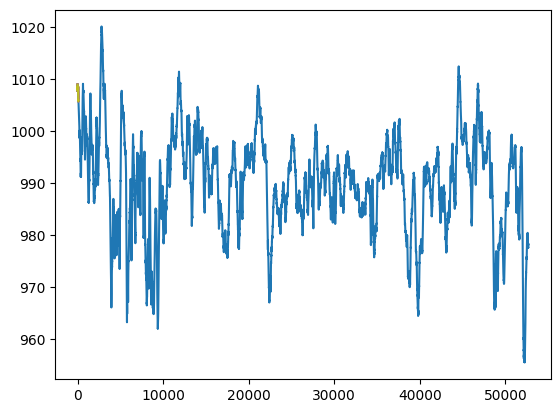

In [49]:
plt.plot(list(x[0:100]), y[0:100])
plt.show()

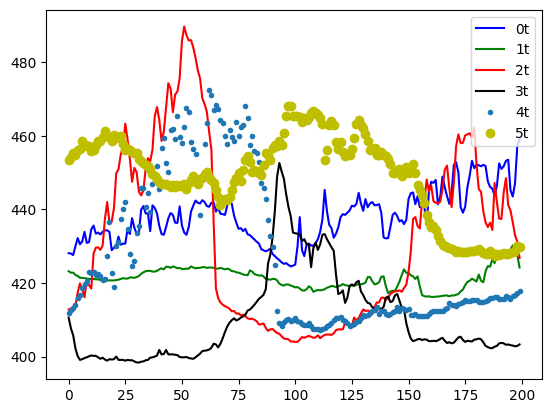

In [57]:
plt.plot(x[:200], yn[:200], 'b', label='0t')
plt.plot(x[:200], yn[10000:10200], 'g', label='1t')
plt.plot(x[:200], yn[20000:20200], 'r-', label='2t')
plt.plot(x[:200], yn[30000:30200], 'k-', label='3t')
plt.plot(x[:200], yn[40000:40200], '.', label='4t')
plt.plot(x[:200], yn[50000:50200], 'yo', label='5t')
plt.legend()
plt.show()

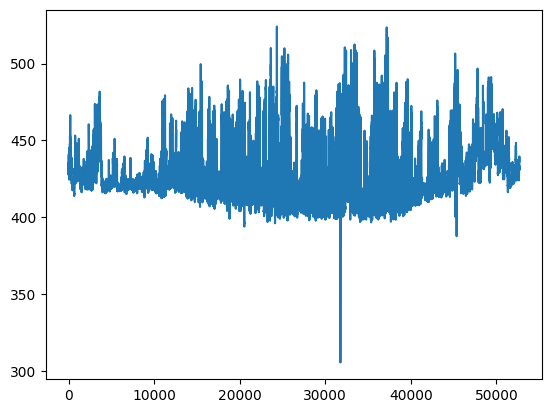

In [58]:
plt.plot(x, yn)
plt.show()

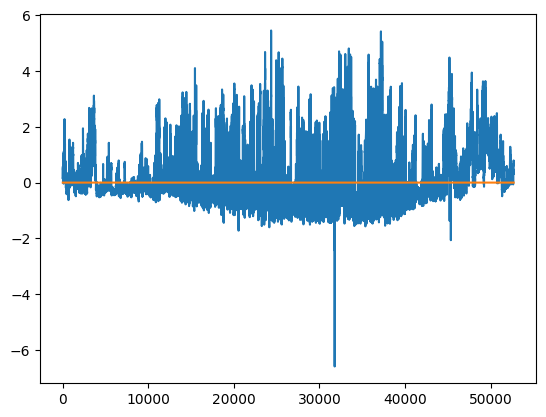

In [82]:
plt.plot(x,data[:,-1])
plt.plot(x,np.zeros(len(x)))
plt.show()

In [84]:
np.sum(data[:,-1]<0) / data[:,-1].size

0.5532298466676787

In [92]:
np.sum(data[border1_test:border2_test,-1]<0) / data[border1_test:border2_test,-1].size

0.27127409496944055

In [91]:
k_ = 10
k0 = 100
k1 = 1000
np.min(data[:,-1]), np.max(data[:,-1]),np.sort(data[:,-1])[k_-1], np.sort(data[:,-1])[-k_],np.sort(data[:,-1])[k0-1], np.sort(data[:,-1])[-k0], np.sort(data[:,-1])[k1-1], np.sort(data[:,-1])[-k1], np.median(data[:,-1])

(-6.58708635320371,
 5.449210047980599,
 -1.5898494385830644,
 5.113492590060048,
 -1.4962888355560264,
 4.155872300253887,
 -1.3476925836895541,
 2.8185060334556304,
 -0.10939048480227985)

In [61]:
from utils.metrics import *

In [65]:
np.sum(np.abs(data[:,-1])>3)

774

In [68]:
np.corrcoef(data.T).shape

(21, 21)

In [94]:
# train 데이터셋의 각 변수별 상관관계
corr_mat_train = np.corrcoef(data[border1_train:border2_train,:].T)

for row in range(21):
    print(corr_mat_train[row, :])

[ 1.         -0.2193186  -0.30312285 -0.28956768 -0.05312096 -0.17681637
 -0.2556732  -0.05248672 -0.26966324 -0.26995186  0.48718961 -0.26312867
 -0.27111642 -0.17591413 -0.06739575 -0.15377147  0.05335949  0.04610676
  0.02473548 -0.16667484  0.14780382]
[-0.2193186   1.          0.99622765  0.78879591 -0.46498442  0.96776531
  0.75307968  0.76862824  0.75208288  0.75259714 -0.95769748  0.04597195
  0.06332919 -0.05955567  0.00674064 -0.05189556  0.42261366  0.43488224
  0.43255501  0.98101207 -0.39676341]
[-0.30312285  0.99622765  1.          0.79611345 -0.44951612  0.96116353
  0.75836994  0.75561855  0.75865285  0.75917969 -0.97869135  0.06851271
  0.08613589 -0.04238916  0.01256723 -0.0371307   0.40799408  0.42062293
  0.42028863  0.97303267 -0.40079484]
[-0.28956768  0.78879591  0.79611345  1.          0.16621255  0.72087312
  0.97688765  0.26275938  0.97637614  0.97675928 -0.81223221 -0.14300212
 -0.15262054  0.03361926  0.06718457  0.0941291   0.08563661  0.09983612
  0.112995

In [95]:
#test 데이터셋의 각 변수별 상관관계
corr_mat_test = np.corrcoef(data[border1_test:border2_test,:].T)

for row in range(21):
    print(corr_mat_test[row, :])

[ 1.          0.05011836 -0.12231194  0.09564976  0.09263012  0.03682263
  0.06244888 -0.01638596  0.03407324  0.03425661  0.47561917 -0.21209699
 -0.19794852  0.03777138 -0.03130125 -0.08012423  0.12711354  0.12347468
  0.11048317  0.10153415  0.04066209]
[ 0.05011836  1.          0.98511137  0.90720874 -0.49704835  0.98752119
  0.90737173  0.7290222   0.906612    0.90673042 -0.8543768   0.29585263
  0.31165249  0.17127001  0.03791152  0.03224673  0.25517207  0.26756901
  0.28001956  0.97504117 -0.52208353]
[-0.12231194  0.98511137  1.          0.8851124  -0.50973075  0.97511124
  0.89105607  0.72734133  0.89519511  0.89528063 -0.9308708   0.33061921
  0.34384609  0.16372507  0.04305485  0.04582201  0.23168114  0.24461799
  0.25924693  0.9514598  -0.52577262]
[ 0.09564976  0.90720874  0.8851124   1.         -0.08897976  0.88824345
  0.98806686  0.39393994  0.98649745  0.98668739 -0.75679157  0.12745636
  0.1368751   0.14478914  0.09342394  0.11393302  0.11511859  0.12584815
  0.137533

In [79]:
# train, val, test의 불균형도 확인하기
print(f"train row : {border1_train} ~ {border2_train}")
print(f"vali row : {border1_vali} ~ {border2_vali}")
print(f"test row : {border1_test} ~ {border2_test}")
for col in range(21):
    print(col)
    print("MEAN_TRAIN", data[border1_train:border2_train, col].mean(), "STD_TRAIN", data[border1_train:border2_train, col].std())
    print("MEAN_VALI", data[border1_vali:border2_vali, col].mean(), "STD_VALI", data[border1_vali:border2_vali, col].std())
    print("MEAN_TEST", data[border1_test:border2_test, col].mean(), "STD_TEST", data[border1_test:border2_test, col].std())
    

train row : 0 ~ 36887
vali row : 36791 ~ 42157
test row : 42061 ~ 52696
0
MEAN_TRAIN 2.070815904387828e-14 STD_TRAIN 0.9999999999999999
MEAN_VALI -0.41678999247852144 STD_VALI 1.0406410694647894
MEAN_TEST -0.153962319977805 STD_TEST 1.24429081634921
1
MEAN_TRAIN -7.39687181207142e-17 STD_TRAIN 1.0
MEAN_VALI 0.09008086617718504 STD_VALI 0.718794680096983
MEAN_TEST -0.7850083954692231 STD_TEST 0.644966239064002
2
MEAN_TRAIN 4.733997959725709e-15 STD_TRAIN 0.9999999999999998
MEAN_VALI 0.12452456996817482 STD_VALI 0.7031802030873209
MEAN_TEST -0.7548444299178075 STD_TEST 0.6343760282661709
3
MEAN_TRAIN -7.39687181207142e-17 STD_TRAIN 1.0
MEAN_VALI 0.4810453984290251 STD_VALI 0.4777399860844514
MEAN_TEST -0.28538201525633694 STD_TEST 0.658743883824557
4
MEAN_TRAIN -5.547653859053565e-17 STD_TRAIN 1.0
MEAN_VALI 0.6286424060165433 STD_VALI 1.0262759345324977
MEAN_TEST 0.9945648340168995 STD_TEST 0.6217662741900054
5
MEAN_TRAIN -9.86249574942856e-17 STD_TRAIN 0.9999999999999999
MEAN_VALI -0.00

In [80]:
# 테스트 데이터의 평균이 0인지 검정

import scipy.stats as stats
test_data = data[border1_test:border2_test]

for col in range(21):
    t_stat, p_value = stats.ttest_1samp(test_data[:,col], 0)
    print({'t-statistic': t_stat, 'p-value': p_value})


{'t-statistic': -12.759712200732551, 'p-value': 5.1389195062909275e-37}
{'t-statistic': -125.5121148689532, 'p-value': 0.0}
{'t-statistic': -122.70408439544549, 'p-value': 0.0}
{'t-statistic': -44.67435926805161, 'p-value': 0.0}
{'t-statistic': 164.95073913414515, 'p-value': 0.0}
{'t-statistic': -166.50421827290126, 'p-value': 0.0}
{'t-statistic': -63.404561973063004, 'p-value': 0.0}
{'t-statistic': -259.3509531441562, 'p-value': 0.0}
{'t-statistic': -63.501716668378336, 'p-value': 0.0}
{'t-statistic': -63.32330003953517, 'p-value': 0.0}
{'t-statistic': 98.11876752217351, 'p-value': 0.0}
{'t-statistic': -3.0891984017544023, 'p-value': 0.002012150190181583}
{'t-statistic': -18.9263938574033, 'p-value': 1.3436231031686882e-78}
{'t-statistic': 17.910149595244874, 'p-value': 1.0685084516697485e-70}
{'t-statistic': -31.230399771442666, 'p-value': 6.178281727055142e-205}
{'t-statistic': 0.2324666050833033, 'p-value': 0.8161800957196772}
{'t-statistic': -154.31640417080112, 'p-value': 0.0}
{'

In [98]:
# train_dataset 형식
train_data_sets = np.array([data[v:v+seq_len+pred_len, :] for v in range(border1_train, border2_train-seq_len-pred_len+1)])
test_data_sets = np.array([data[v:v+seq_len+pred_len, :] for v in range(border1_test, border2_test-seq_len-pred_len+1)])

In [102]:
train_data_sets.shape, test_data_sets.shape # 형식 분석

((36696, 192, 21), (10444, 192, 21))